# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
!pip install tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu
ERROR: No matching distribution found for tensorflow-gpu


In [3]:
!pip install --upgrade grpcio

In [4]:
!pip install tqdm

In [5]:
!pip install bert-for-tf2

In [6]:
!pip install sentencepiece

In [7]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data


In [8]:
df = pd.read_csv('../Data/Fake news detection/data.csv', 
                   delimiter=',')
df.drop(df.columns[[0,1]], axis = 1, inplace = True)
df.columns = ['Body', 'Label']
df.head(15)
df["Body"] = df["Body"].astype(str)
df["Label"] = df["Label"].astype(str)

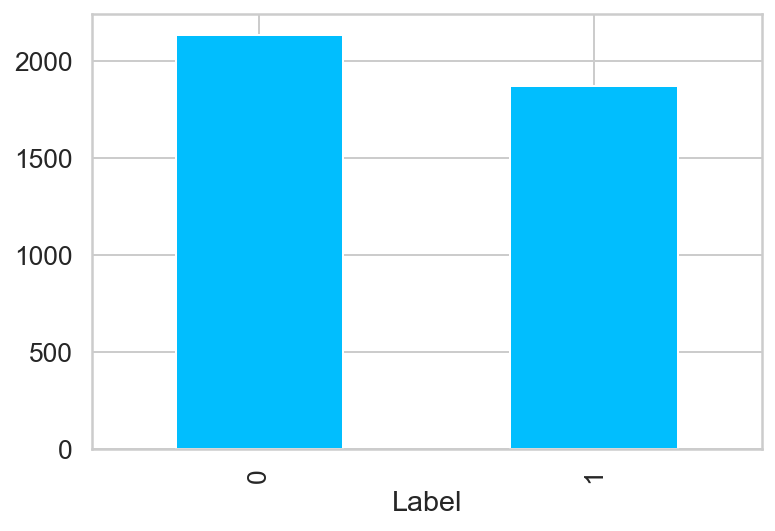

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [10]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

In [11]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [12]:
new_text, new_label = balanceClasses(df['Body'], df['Label'])

In [13]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Body']
data_df['Label'] = new_label
data_df = pd.concat([df, data_df])

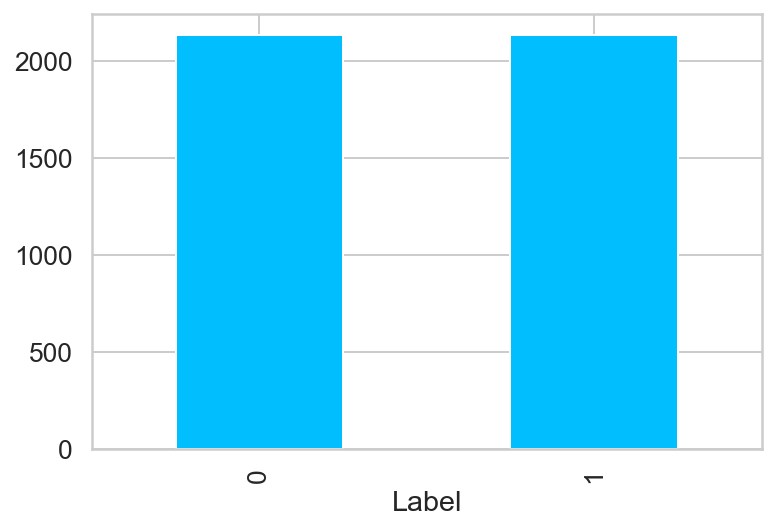

In [14]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [15]:
df = data_df

In [16]:
df.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [17]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Body,Label
0,(CNN) — Against the backdrop of bright blue sk...,1
1,Teacher Sparks Outrage By Asking Kids To Make ...,0
2,Ole Smoky Tennessee Moonshine Becomes A Proud ...,0
3,By Aaron Kesel\nTensions are rising at a quick...,0
4,By Carey Wedler\nThe Federal Emergency Managem...,0
...,...,...
4268,Red Flag Warning: These California Wildfires A...,0
4269,Vendange Carmel Inn and Suites Announces New W...,0
4270,Dozens prayed at a revered Hindu temple on the...,1
4271,"(CNN) Herpes has been around a long time, to s...",1


Data Preprocessing

In [18]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Body'] = df['Body'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Body'] = df['Body'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Body'] = df['Body'].apply(lambda x: ReplaceFourColon(x))

In [19]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Body'] = df['Body'].apply(lambda x: textPattern(x))

In [20]:
df = df[df.Body != '']

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [22]:
df.head()

,Body,Label
0,CNN Against the backdrop of bright blue sky a...,1
1,Teacher Sparks Outrage By Asking Kids To Make ...,0
2,Ole Smoky Tennessee Moonshine Becomes A Proud ...,0
3,By Aaron Kesel Tensions are rising at a quicke...,0
4,By Carey Wedler The Federal Emergency Manageme...,0


/Users/syedshayanjamal/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


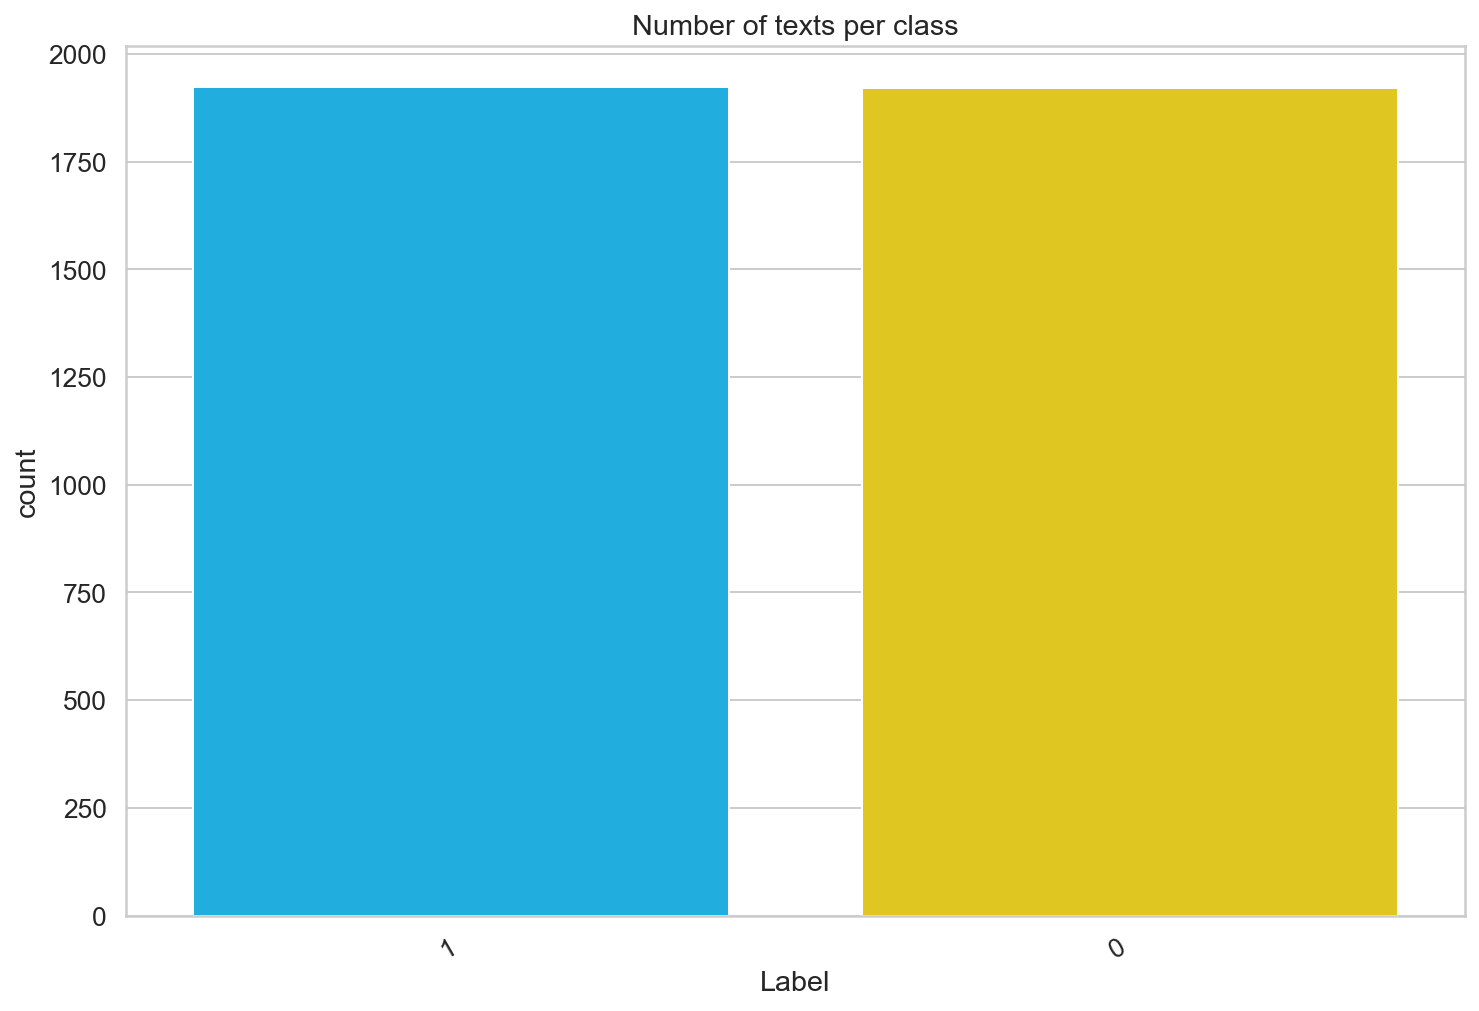

In [23]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# FAKE NEWS Detection with BERT


In [24]:
os.makedirs("model", exist_ok=True)

In [25]:
!mv uncased_L-12_H-768_A-12/ model

mv: uncased_L-12_H-768_A-12/: No such file or directory


In [26]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [27]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Body"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [28]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [29]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [30]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

3845it [00:34, 111.85it/s]
428it [00:04, 106.95it/s]


max seq_len 7126


In [31]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f899cd4c490> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [34]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
217/217 [==============================] - 4925s 23s/step - loss: 0.3392 - acc: 0.9734 - val_loss: 0.3410 - val_acc: 0.9714
Epoch 2/5
217/217 [==============================] - 4203s 19s/step - loss: 0.3350 - acc: 0.9772 - val_loss: 0.3439 - val_acc: 0.9688
Epoch 3/5
217/217 [==============================] - 3945s 18s/step - loss: 0.3302 - acc: 0.9824 - val_loss: 0.3340 - val_acc: 0.9792
Epoch 4/5
217/217 [==============================] - 3520s 16s/step - loss: 0.3288 - acc: 0.9844 - val_loss: 0.3305 - val_acc: 0.9818
Epoch 5/5
217/217 [==============================] - 2669s 12s/step - loss: 0.3229 - acc: 0.9902 - val_loss: 0.3282 - val_acc: 0.9844


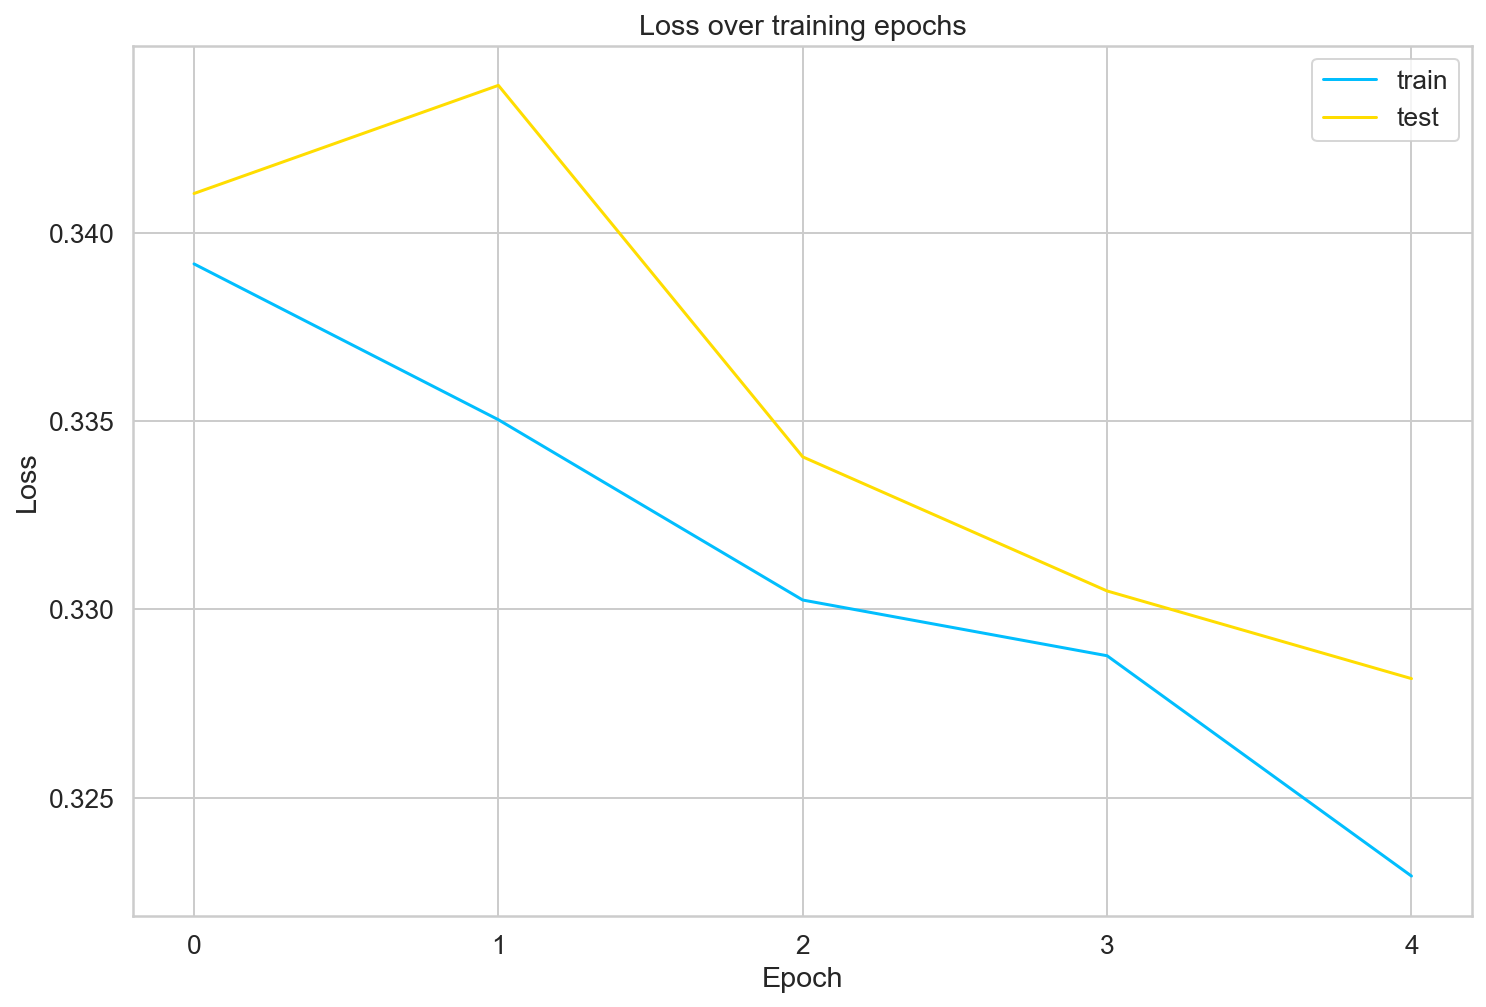

In [35]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

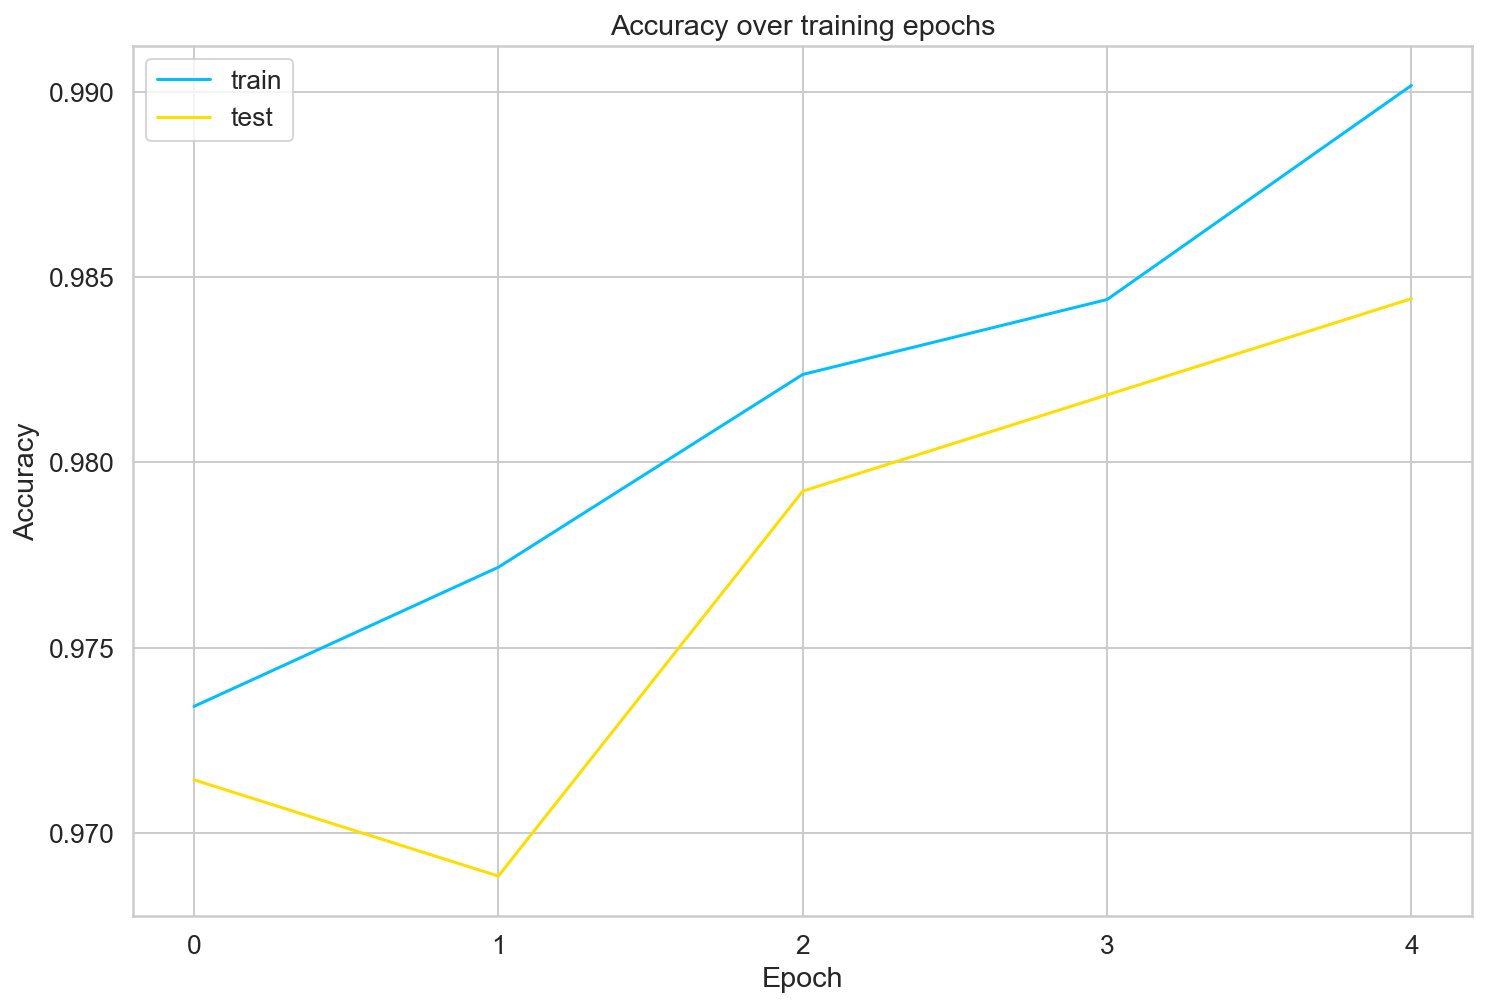

In [36]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [37]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

14/14 [==============================] - 109s 8s/step - loss: 0.3286 - acc: 0.9836
train acc 0.9921976327896118
test acc 0.9836448431015015


In [38]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [39]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       213
           1       0.99      0.98      0.98       215

    accuracy                           0.98       428
   macro avg       0.98      0.98      0.98       428
weighted avg       0.98      0.98      0.98       428



In [40]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

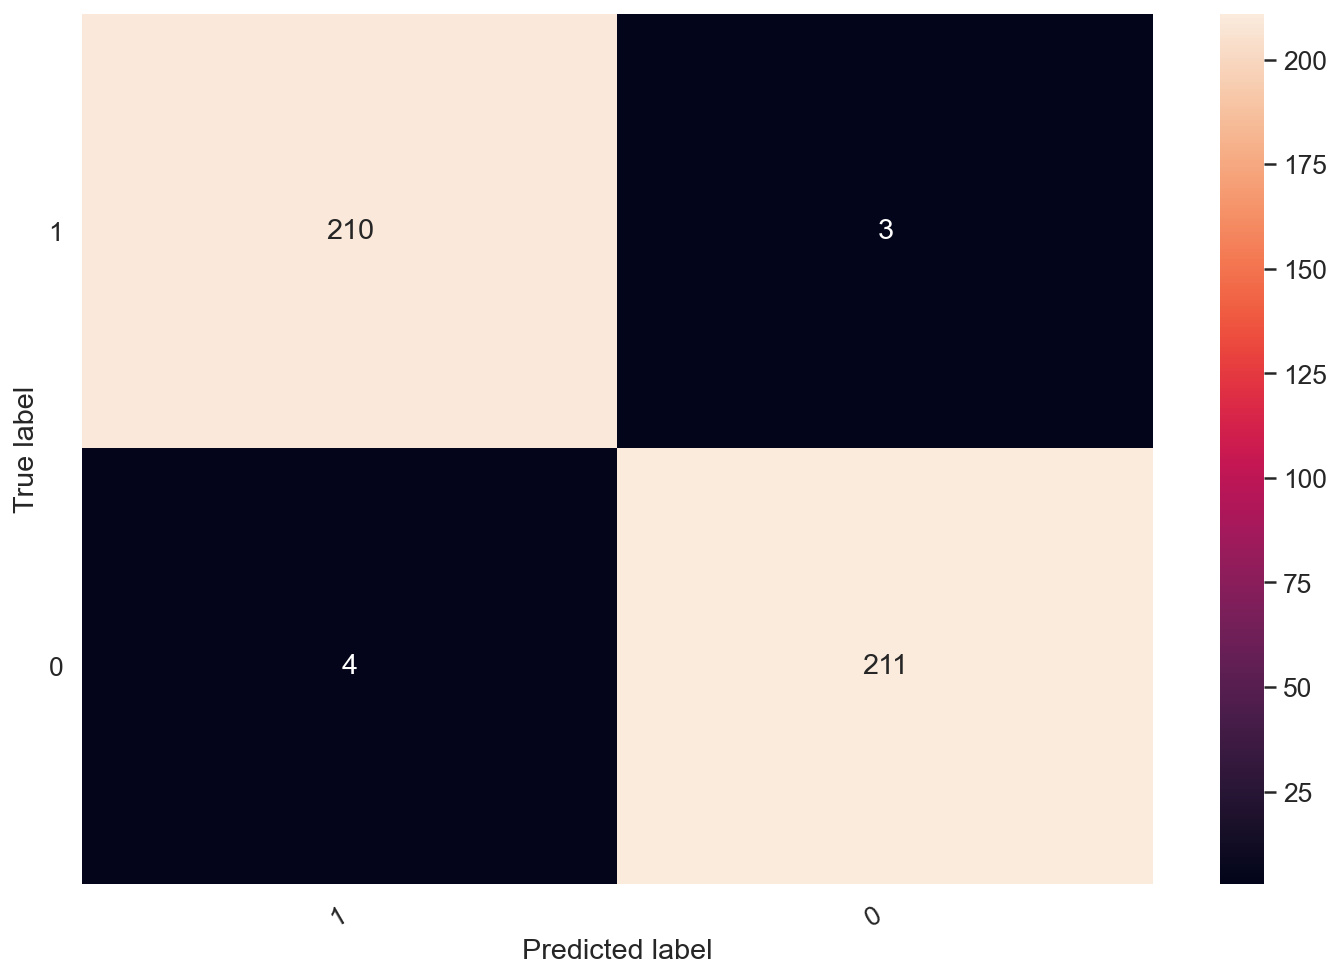

In [41]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');